# Agente BDI con Q-Learning en CARLA

## Alcance

El objetivo de la presente prueba de concepto es diseñar una Arquitectura básica de Agentes BDI con Aprendizaje por Refuerzo, basada en Building Blocks, lo mas modular posible que permita ensamblar y desensamblar agentes basados en utilidad en el entorno de simulación CARLA en distintos escenarios de conducción para un vehiculo autonomo

## Arquitectura propuesta

La primera aproximación de diseño, definirá una serie de Bloques Funcionales, que será posible ensamblar y desensamblar en la prueba de concepto de distintos escenarios de conducción, medienta interfaces de diseño concretas


### Bloque de Percepción (Perception Block)

- Encargado de interpretar los datos del entorno
- Incluye procesamiento de sensores (cámara, LIDAR, etc.)
- Genera un modelo interno del entorno

### Bloque de Toma de Decisiones (Decision Making Block)

- Implementa la arquitectura BDI (Beliefs, Desires, Intentions)
- Coordina los diferentes módulos de aprendizaje
- Gestiona los objetivos y prioridades

### Bloque de Aprendizaje por Refuerzo (RL Block)

- Implementación modular de Q-Learning
- Diseñado para ser intercambiable (podría reemplazarse por DQN, PPO, etc.)
- Interfaz estandarizada para integración

### Bloque de Control (Control Block)

- Transforma decisiones en acciones de control
- Implementa controladores PID/MPC
- Gestión de actuadores

### Bloque de Interfaz con CARLA (CARLA Interface Block)

- Abstraction layer para el simulador
- Normalización de datos del entorno
- Conversión entre representaciones

## Modulo de Percepcion

Este módulo implementado en python con pytorch sobre CARLA será el encargado de interpretar los datos de entorno

In [ ]:
from BB_Communication_Manager import ACLMessage, Performative, CommunicationManager

class PerceptionBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("perception", self)
        
        # Configuración de sensores CARLA
        self.camera = None
        self.lidar = None
    
    def setup_carla_sensors(self, vehicle):
        # Configuración de sensores (similar a tu implementación actual)
        pass
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.REQUEST and message.content == "update_percepts":
            self._update_and_send_percepts()
    
    def _update_and_send_percepts(self):
        # Obtener datos de los sensores y procesar
        percepts = {
            "vehicle_position": self._get_vehicle_position(),
            "obstacles": self._detect_obstacles(),
            "route_info": self._get_route_info()
        }
        
        # Crear mensaje FIPA ACL
        msg = ACLMessage(
            performative=Performative.INFORM,
            sender="perception",
            receivers=["bdi_engine"],
            content=percepts,
            protocol="perception_update"
        )
        
        self.comm_manager.send(msg)

## Modulo de Comunicaciones

En este módulo en una primera aproximación para crear una interfaz de intercambio de mensajes, se ha implementado un protocolo FIPA-ACL básico, especifico en el intercambio de mensajes entre distintos tipos de agentes

In [ ]:
from dataclasses import dataclass
from enum import Enum
from typing import List, Any
from typing import Optional
from collections import defaultdict

class Performative(Enum):
    INFORM = "inform"
    REQUEST = "request"
    QUERY_REF = "query-ref"
    PROPOSE = "propose"
    ACCEPT_PROPOSAL = "accept-proposal"
    REJECT_PROPOSAL = "reject-proposal"
    CFP = "cfp"
    CONFIRM = "confirm"

@dataclass
class ACLMessage:
    performative: Performative
    sender: str
    receivers: List[str]
    content: Optional[Any] = None
    language: str = "fipa-sl"
    ontology: str = "carla-bdi-rl"
    protocol: Optional[str] = None
    conversation_id: Optional[str] = None
    reply_with: Optional[str] = None
    in_reply_to: Optional[str] = None
    reply_by: Optional[int] = None

class CommunicationManager:
    def __init__(self):
        self._message_handlers = defaultdict(list)
        self._blocks = {}
    
    def register_block(self, block_name: str, block_instance: Any):
        self._blocks[block_name] = block_instance
    
    def subscribe(self, performative: Performative, handler):
        self._message_handlers[performative].append(handler)
    
    def send(self, message: ACLMessage):
        for receiver in message.receivers:
            if receiver in self._blocks:
                self._blocks[receiver].receive_message(message)
        
        for handler in self._message_handlers.get(message.performative, []):
            handler(message)
    
    def broadcast(self, message: ACLMessage):
        for block in self._blocks.values():
            if hasattr(block, 'receive_message'):
                block.receive_message(message)

## Modulo de Toma de Decisiones (Decision-Making)

En este módulo se implementa un Agente BDI, para estructurar la toma de decisiones empleando un esquema basado en las creencias del agente, las cuales se especifican a partir de como percibe en entorno de conducción el Agente. Los deseos, donde se especificaran los objetivos o metas que intentará cumplir el Agente, y finalmente las intenciones que a partir de toda esta información permitira proyectar las actuaciones que será la forma de inter-relacinarse con el entorno percibido.

In [ ]:
from BB_Communication_Manager import ACLMessage, Performative, CommunicationManager

class BDIEngineBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("bdi_engine", self)
        
        # Componentes BDI
        self.beliefs = {}
        self.desires = {"primary": "reach_target"}
        self.intentions = []
        
        # Suscripción a mensajes
        self.comm_manager.subscribe(Performative.INFORM, self._handle_inform)
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.INFORM:
            self._handle_inform(message)
    
    def _handle_inform(self, message: ACLMessage):
        if message.protocol == "perception_update":
            self._update_beliefs(message.content)
            self._deliberate()
    
    def _update_beliefs(self, percepts):
        self.beliefs.update({
            "position": percepts["vehicle_position"],
            "obstacles": percepts["obstacles"],
            "route_info": percepts["route_info"]
        })
    
    def _deliberate(self):
        # Lógica de deliberación BDI
        if self._target_reached():
            self.desires["primary"] = "target_reached"
            return
        
        # Solicitar acción al módulo RL
        msg = ACLMessage(
            performative=Performative.QUERY_REF,
            sender="bdi_engine",
            receivers=["rl_learning"],
            content={
                "state": self._get_current_state(),
                "valid_actions": self._get_valid_actions()
            },
            protocol="action_request"
        )
        self.comm_manager.send(msg)
    
    def _get_current_state(self):
        # Convertir creencias a estado para RL
        return (self.beliefs["position"].x, self.beliefs["position"].y)

## Modulo de Aprendizaje por Refuerzo

Este módulo implementa un algoritmo básico Q-Learning con políticas ε-greedy en la selección de acciones a realizar

In [ ]:
from BB_Communication_Manager import ACLMessage, Performative, CommunicationManager
from collections import defaultdict
import random
import numbers as np

class RLLearningBlock:
    
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("rl_learning", self)
        
        # Configuración Q-Learning
        self.q_table = defaultdict(lambda: np.zeros(4))
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.action_effects = {
            'UP': (0, 1),
            'DOWN': (0, -1),
            'LEFT': (-1, 0),
            'RIGHT': (1, 0)
        }
        
        # Suscripción a mensajes
        self.comm_manager.subscribe(Performative.QUERY_REF, self._handle_query)
        self.comm_manager.subscribe(Performative.INFORM, self._handle_reward)
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.QUERY_REF:
            self._handle_query(message)
        elif message.performative == Performative.INFORM and message.protocol == "reward_update":
            self._handle_reward(message)
    
    def _handle_query(self, message: ACLMessage):
        if message.protocol == "action_request":
            state = message.content["state"]
            valid_actions = message.content["valid_actions"]
            
            # Selección de acción ε-greedy
            if random.random() < self.epsilon:
                action = random.choice(valid_actions)
            else:
                action = self.actions[np.argmax(self.q_table[state])]
            
            # Responder con la acción seleccionada
            reply = ACLMessage(
                performative=Performative.INFORM,
                sender="rl_learning",
                receivers=[message.sender],
                content={"action": action},
                in_reply_to=message.reply_with,
                protocol="action_response"
            )
            self.comm_manager.send(reply)
    
    def _handle_reward(self, message: ACLMessage):
        data = message.content
        self._update_q_table(
            data["state"],
            data["action"],
            data["reward"],
            data["next_state"]
        )
    
    def _update_q_table(self, state, action, reward, next_state):
        action_idx = self.actions.index(action)
        current_q = self.q_table[state][action_idx]
        max_next_q = np.max(self.q_table[next_state])
        
        # Fórmula Q-Learning
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action_idx] = new_q

## Bloque de Control (Control Block)

El módulo de control trasforma las decisiones en acciones. La inclusión de un controlador PID (Proporcional-Integral-Derivativo) en esta arquitectura presenta varias particularidades importantes que vale la pena analizar:

El controlador PID opera como un mecanismo de bajo nivel que complementa la toma de decisiones de alto nivel del Q-Learning y el BDI:
- Nivel Alto (BDI + Q-Learning): Decide la dirección general ("LEFT", "RIGHT", etc.)
- Nivel Bajo (PID): Implementa el control fino del ángulo de dirección para ejecutar la acción

### Especificidad para Dirección
El PID se usa exclusivamente para el control del ángulo de dirección (steering), no para la velocidad, lo que es particular porque:
- La salida del PID se mapea directamente al ángulo de las ruedas
- El throttle (aceleración) se maneja de forma constante (0.5 en el código)

### Integración con Acciones Discretas
El PID suaviza la transición entre las acciones discretas del Q-Learning:
- Sin PID: Cambios bruscos entre LEFT/RIGHT
- Con PID: Transiciones suaves basadas en error de trayectoria

### Sintonización para Entorno Dinámico
Los parámetros del PID (Kp=0.05, Ki=0.001, Kd=0.02) están sintonizados para:
- Vehículos de CARLA (respuesta física específica)
- Entorno urbano (necesidad de giros moderados)
- Frecuencia de actualización de 60Hz

### Ventajas de esta Implementación
Suavizado de Movimientos: Elimina cambios bruscos de dirección
- Compensación de Errores: Corrige desviaciones de la trayectoria ideal
- Mayor Estabilidad: Previene oscilaciones en rectas
- Adaptabilidad Implícita: Ajusta continuamente a las condiciones del camino

### Limitaciones y Consideraciones
- Dependencia de Parámetros: Requiere sintonización cuidadosa
- Efecto Windup: El término integral puede causar sobredisparo
- Interacción con Q-Learning: Las recompensas deben diseñarse considerando el comportamiento del PID



In [ ]:
# En ActionExecutionBlock._execute_action()

steer = self._action_to_steering(action)                          # Conversión discreta a continua
error = self._calculate_tracking_error()                          # Error respecto a la trayectoria deseada
steer_correction = self.controller.control(error)                 # Ajuste fino con PID
final_steer = np.clip(steer + steer_correction, -1.0, 1.0)
self.vehicle.apply_control(carla.VehicleControl(throttle=0.5, steer=final_steer, brake=0))

In [ ]:
import carla
from BB_Communication_Manager import ACLMessage, Performative, CommunicationManager


class PIDController:
    """PID Controller for steering."""
    def __init__(self, Kp, Ki, Kd, dt=1.0/60):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0
        self.prev_error = 0

    def control(self, error):
        """Compute PID control output."""
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative


class ActionExecutionBlock:
    def __init__(self, comm_manager: CommunicationManager, vehicle):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("action_exec", self)
        self.vehicle = vehicle
        
        # Controlador PID (de tu implementación original)
        self.controller = PIDController(Kp=0.05, Ki=0.001, Kd=0.02)
        
        # Suscripción a mensajes
        self.comm_manager.subscribe(Performative.INFORM, self._handle_action)
    
    def receive_message(self, message: ACLMessage):
        if message.protocol == "action_response":
            self._execute_action(message.content["action"])
    
    def _execute_action(self, action):
        if action == "STOP":
            self.vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
            return
        
        # Convertir acción a control del vehículo
        steer = self._action_to_steering(action)
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.5, steer=steer, brake=0))
        
        # Obtener nuevo estado para cálculo de recompensa
        new_position = self.vehicle.get_location()
        msg = ACLMessage(
            performative=Performative.INFORM,
            sender="action_exec",
            receivers=["perception"],
            content={"request": "position_update"},
            protocol="state_update"
        )
        self.comm_manager.send(msg)

## Bloque de Interfaz con CARLA

Este módulo abstraé el módulo o interface con CARLA

In [ ]:
import threading
import time

from BB_Communication_Manager import ACLMessage, Performative, CommunicationManager
from BB_Perception import PerceptionBlock
from BB_Communication_Manager import CommunicationManager
from BB_BDIAgent import BDIEngineBlock
from BB_RLAlgorithm import RLLearningBlock
from BB_ExecAct import ActionExecutionBlock


class BDIVehicleAgent:
    def __init__(self, world, client):
        self.world = world
        self.client = client
        self.vehicle = None
        
        # Crear Communication Manager
        self.comm_manager = CommunicationManager()
        
        # Inicializar bloques
        self.perception = PerceptionBlock(self.comm_manager)
        self.bdi_engine = BDIEngineBlock(self.comm_manager)
        self.rl_learning = RLLearningBlock(self.comm_manager)
        
        # Spawnear vehículo y sensores
        self._spawn_vehicle()
        self.perception.setup_carla_sensors(self.vehicle)
        
        # Action Execution necesita referencia al vehículo
        self.action_exec = ActionExecutionBlock(self.comm_manager, self.vehicle)
        
        # Configurar ciclo de percepción-acción
        self._setup_agent_loop()
    
    def _spawn_vehicle(self):
        # (Implementación similar a tu código original)
        pass
    
    def _setup_agent_loop(self):
        # Programar actualización periódica de percepciones
        def update_loop():
            while True:
                msg = ACLMessage(
                    performative=Performative.REQUEST,
                    sender="agent_loop",
                    receivers=["perception"],
                    content="update_percepts",
                    protocol="perception_update"
                )
                self.comm_manager.send(msg)
                time.sleep(1.0/60)  # 60 Hz
                
        self.agent_thread = threading.Thread(target=update_loop)
        self.agent_thread.daemon = True
        self.agent_thread.start()
    
    def run(self):
        try:
            while True:
                self.world.tick()
                time.sleep(1.0/60)
        except KeyboardInterrupt:
            self.vehicle.destroy()

## Ensamblado

En el siguiente módulo se realiza un ensamblado a modo de PoC para comprobar interoperabilidad entre los distintos módulos de la arquitectura propuesta.


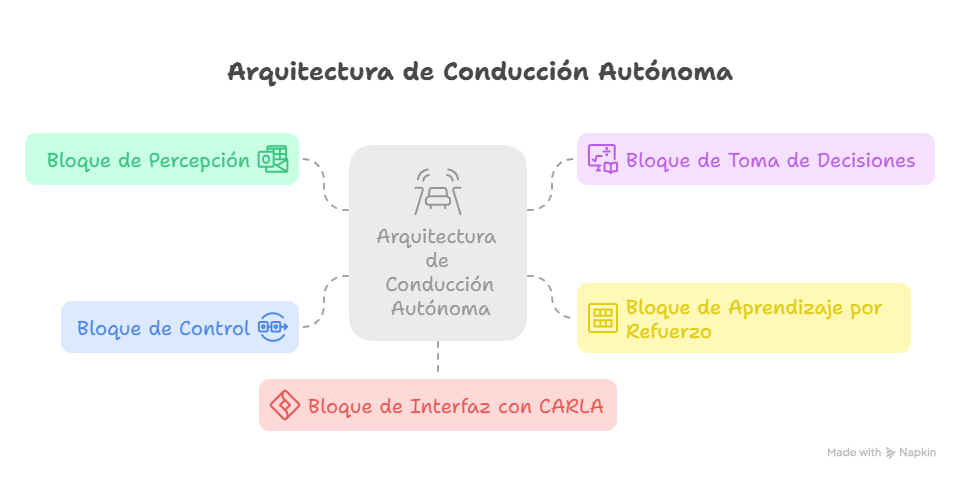

In [1]:
#!/usr/bin/env python3
import carla
import time
import threading
import numpy as np
from collections import defaultdict
from typing import List, Dict, Optional, Any
from enum import Enum
from dataclasses import dataclass
import random


# -------------------------------------------------------------------
# 4. Main execution
# -------------------------------------------------------------------
def main():
    # Connect to CARLA server
    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)
    
    # Set synchronous mode
    world = client.get_world()
    settings = world.get_settings()
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 1.0/60
    world.apply_settings(settings)
    
    try:
        # Create and run agent
        agent = BDIVehicleAgent(world, client)
        agent.run()
    finally:
        # Restore asynchronous mode
        settings.synchronous_mode = False
        world.apply_settings(settings)

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'carla'

## Anexo I: Ensamblado de los BB's en un Modulo de Ejecucion

In [3]:
!conda activate carla

In [1]:
#!/usr/bin/env python3
import carla
import time
import threading
import numpy as np
from collections import defaultdict
from typing import List, Dict, Optional, Any
from enum import Enum
from dataclasses import dataclass
import random

# -------------------------------------------------------------------
# 1. Definiciones base (FIPA ACL y Building Blocks)
# -------------------------------------------------------------------
class Performative(Enum):
    INFORM = "inform"
    REQUEST = "request"
    QUERY_REF = "query-ref"
    PROPOSE = "propose"
    ACCEPT_PROPOSAL = "accept-proposal"
    REJECT_PROPOSAL = "reject-proposal"
    CFP = "cfp"
    CONFIRM = "confirm"

@dataclass
class ACLMessage:
    performative: Performative
    sender: str
    receivers: List[str]
    content: Optional[Any] = None
    language: str = "fipa-sl"
    ontology: str = "carla-bdi-rl"
    protocol: Optional[str] = None
    conversation_id: Optional[str] = None
    reply_with: Optional[str] = None
    in_reply_to: Optional[str] = None
    reply_by: Optional[int] = None

class CommunicationManager:
    def __init__(self):
        self._message_handlers = defaultdict(list)
        self._blocks = {}
    
    def register_block(self, block_name: str, block_instance: Any):
        self._blocks[block_name] = block_instance
    
    def subscribe(self, performative: Performative, handler):
        self._message_handlers[performative].append(handler)
    
    def send(self, message: ACLMessage):
        for receiver in message.receivers:
            if receiver in self._blocks:
                self._blocks[receiver].receive_message(message)
        
        for handler in self._message_handlers.get(message.performative, []):
            handler(message)

# -------------------------------------------------------------------
# 2. Implementación de los Building Blocks
# -------------------------------------------------------------------
class PerceptionBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("perception", self)
        self.vehicle = None
        self.route = []
    
    def setup_carla_sensors(self, vehicle, route):
        self.vehicle = vehicle
        self.route = route
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.REQUEST and message.content == "update_percepts":
            self._update_and_send_percepts()
    
    def _update_and_send_percepts(self):
        if not self.vehicle:
            return
            
        position = self.vehicle.get_location()
        target = self.route[-1][0].transform.location if self.route else None
        
        percepts = {
            "vehicle_position": position,
            "target_position": target,
            "distance_to_target": math.sqrt((position.x - target.x)**2 + (position.y - target.y)**2) if target else 0
        }
        
        msg = ACLMessage(
            performative=Performative.INFORM,
            sender="perception",
            receivers=["bdi_engine"],
            content=percepts,
            protocol="perception_update"
        )
        self.comm_manager.send(msg)

class BDIEngineBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("bdi_engine", self)
        self.beliefs = {}
        self.desires = {"primary": "reach_target"}
        self.intentions = []
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.INFORM and message.protocol == "perception_update":
            self._update_beliefs(message.content)
            self._deliberate()
    
    def _update_beliefs(self, percepts):
        self.beliefs.update({
            "position": percepts["vehicle_position"],
            "target": percepts["target_position"],
            "distance": percepts["distance_to_target"]
        })
    
    def _deliberate(self):
        if self._target_reached():
            self.desires["primary"] = "target_reached"
            self._send_action("STOP")
            return
        
        state = self._get_current_state()
        msg = ACLMessage(
            performative=Performative.QUERY_REF,
            sender="bdi_engine",
            receivers=["rl_learning"],
            content={"state": state},
            protocol="action_request"
        )
        self.comm_manager.send(msg)
    
    def _target_reached(self):
        return self.beliefs.get("distance", float('inf')) < 2.0
    
    def _get_current_state(self):
        pos = self.beliefs["position"]
        return (int(pos.x), int(pos.y))
    
    def _send_action(self, action):
        msg = ACLMessage(
            performative=Performative.INFORM,
            sender="bdi_engine",
            receivers=["action_exec"],
            content={"action": action},
            protocol="action_execution"
        )
        self.comm_manager.send(msg)

class RLLearningBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("rl_learning", self)
        self.q_table = defaultdict(lambda: np.zeros(4))
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.action_effects = {
            'UP': (0, 1),
            'DOWN': (0, -1),
            'LEFT': (-1, 0),
            'RIGHT': (1, 0)
        }
        self.epsilon = 1.0
        self.alpha = 0.2
        self.gamma = 0.99
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.QUERY_REF and message.protocol == "action_request":
            self._handle_action_request(message)
        elif message.performative == Performative.INFORM and message.protocol == "reward_update":
            self._handle_reward_update(message.content)
    
    def _handle_action_request(self, message):
        state = message.content["state"]
        
        # ε-greedy action selection
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            action = self.actions[np.argmax(self.q_table[state])]
        
        # Decay epsilon
        self.epsilon = max(0.05, self.epsilon * 0.999)
        
        reply = ACLMessage(
            performative=Performative.INFORM,
            sender="rl_learning",
            receivers=[message.sender],
            content={"action": action},
            in_reply_to=message.reply_with,
            protocol="action_response"
        )
        self.comm_manager.send(reply)
    
    def _handle_reward_update(self, content):
        state = content["state"]
        action = content["action"]
        reward = content["reward"]
        next_state = content["next_state"]
        
        action_idx = self.actions.index(action)
        current_q = self.q_table[state][action_idx]
        max_next_q = np.max(self.q_table[next_state])
        
        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action_idx] = new_q

class ActionExecutionBlock:
    def __init__(self, comm_manager: CommunicationManager):
        self.comm_manager = comm_manager
        self.comm_manager.register_block("action_exec", self)
        self.vehicle = None
    
    def set_vehicle(self, vehicle):
        self.vehicle = vehicle
    
    def receive_message(self, message: ACLMessage):
        if message.performative == Performative.INFORM and message.protocol == "action_execution":
            self._execute_action(message.content["action"])
    
    def _execute_action(self, action):
        if not self.vehicle:
            return
            
        if action == "STOP":
            self.vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
            return
        
        # Simple action to control mapping
        steer = 0
        if action == 'LEFT':
            steer = -0.5
        elif action == 'RIGHT':
            steer = 0.5
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.5, steer=steer, brake=0))
        
        # Calculate reward
        current_pos = self.vehicle.get_location()
        current_state = (int(current_pos.x), int(current_pos.y))
        
        # Simulate next state based on action
        dx, dy = self.action_effects[action]
        next_state = (current_state[0] + dx, current_state[1] + dy)
        
        # Simple reward calculation
        reward = self._calculate_reward(current_state, action, next_state)
        
        # Send reward update
        msg = ACLMessage(
            performative=Performative.INFORM,
            sender="action_exec",
            receivers=["rl_learning"],
            content={
                "state": current_state,
                "action": action,
                "reward": reward,
                "next_state": next_state
            },
            protocol="reward_update"
        )
        self.comm_manager.send(msg)
    
    def _calculate_reward(self, state, action, next_state):
        # Simplified reward calculation
        return 10 if action == 'RIGHT' else -1  # Just for demo purposes

# -------------------------------------------------------------------
# 3. Clase principal del agente y main loop
# -------------------------------------------------------------------
class BDIVehicleAgent:
    def __init__(self, world, client):
        self.world = world
        self.client = client
        self.vehicle = None
        self.route = []
        
        # Create Communication Manager
        self.comm_manager = CommunicationManager()
        
        # Initialize blocks
        self.perception = PerceptionBlock(self.comm_manager)
        self.bdi_engine = BDIEngineBlock(self.comm_manager)
        self.rl_learning = RLLearningBlock(self.comm_manager)
        self.action_exec = ActionExecutionBlock(self.comm_manager)
        
        # Setup Carla simulation
        self._setup_carla()
        
        # Start perception loop
        self._start_perception_loop()
    
    def _setup_carla(self):
        """Initialize CARLA simulation with vehicle and route"""
        spawn_points = self.world.get_map().get_spawn_points()
        a = spawn_points[50].location
        b = spawn_points[100].location
        
        # Create route
        grp = GlobalRoutePlanner(self.world.get_map(), sampling_resolution=2)
        self.route = grp.trace_route(a, b)
        
        # Spawn vehicle
        blueprint_lib = self.world.get_blueprint_library()
        vehicle_bp = random.choice(blueprint_lib.filter('vehicle.*'))
        waypoint = self.world.get_map().get_waypoint(a)
        vehicle_transform = carla.Transform(
            carla.Location(waypoint.transform.location.x, waypoint.transform.location.y, 2),
            waypoint.transform.rotation
        )
        self.vehicle = self.world.spawn_actor(vehicle_bp, vehicle_transform)
        
        # Setup blocks with vehicle reference
        self.perception.setup_carla_sensors(self.vehicle, self.route)
        self.action_exec.set_vehicle(self.vehicle)
        
        # Draw route
        for i, w in enumerate(self.route):
            color = carla.Color(r=255, g=0, b=0) if i % 10 == 0 else carla.Color(r=0, g=0, b=255)
            self.world.debug.draw_string(
                w[0].transform.location, 
                'O', 
                draw_shadow=False, 
                color=color, 
                life_time=120.0
            )
    
    def _start_perception_loop(self):
        """Start thread for periodic perception updates"""
        def perception_loop():
            while True:
                msg = ACLMessage(
                    performative=Performative.REQUEST,
                    sender="agent_loop",
                    receivers=["perception"],
                    content="update_percepts",
                    protocol="perception_update"
                )
                self.comm_manager.send(msg)
                time.sleep(1.0/10)  # 10 Hz update rate
        
        self.perception_thread = threading.Thread(target=perception_loop)
        self.perception_thread.daemon = True
        self.perception_thread.start()
    
    def run(self):
        """Main simulation loop"""
        try:
            while True:
                self.world.tick()
                time.sleep(1.0/60)
        except KeyboardInterrupt:
            print("Destroying vehicle...")
            if self.vehicle:
                self.vehicle.destroy()
            print("Done.")

# -------------------------------------------------------------------
# 4. Main execution
# -------------------------------------------------------------------
def main():
    # Connect to CARLA server
    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)
    
    # Set synchronous mode
    world = client.get_world()
    settings = world.get_settings()
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 1.0/60
    world.apply_settings(settings)
    
    try:
        # Create and run agent
        agent = BDIVehicleAgent(world, client)
        agent.run()
    finally:
        # Restore asynchronous mode
        settings.synchronous_mode = False
        world.apply_settings(settings)

if __name__ == "__main__":
    main()

RuntimeError: time-out of 10000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000